In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

from scripts.neutMakeJson import main as MakeNeutJson
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas

Welcome to JupyROOT 6.27/01


In [2]:
ROOT.rand = ROOT.TRandom3()

def poisson(x, mean):
    """
    ensure that mean is some int
    """
    assert isinstance(mean, int), "can only have integer mean values"
    x = int(x) # poisson only makes sense for int args
    return ROOT.TMath.Poisson(x,mean)

def gamma(x, mean):
    return 1 - ROOT.TMath.Gamma(x, mean)

def uniform():
    return ROOT.rand.Uniform()

def randomPoisson(mean, nSamples):
    """
    randomly sample the poisson to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    samples = [ROOT.rand.Poisson(mean) for i in range(nSamples)]
    return samples

def randomErlang(mean, nEvts, nSamples):
    """
    randomly sample the gamma to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    def erlang():
        return -1 * np.sum([ROOT.TMath.Log(ROOT.rand.Uniform()) for i in range(nEvts)]) / mean
    samples = [erlang() for i in range(nSamples)]
    return samples

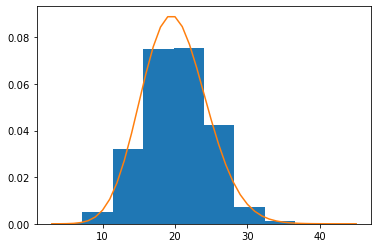

In [3]:
mean, nSamples = 20, int(3e5)
samples = randomPoisson(mean, nSamples)
a = plt.hist(samples, density=True)
x = np.arange(int(np.min(a[1])), int(np.max(a[1]))+1)
p1 = [poisson(i, mean) for i in x]
plt.plot(x,p1)

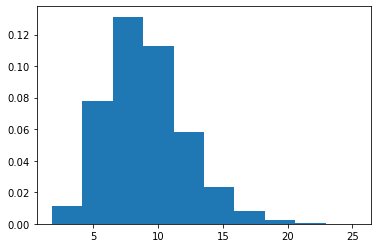

In [4]:
mean, nEvts, nSamples = 1, 9, int(1e4)
samples = randomErlang(mean, nEvts, nSamples)
a = plt.hist(samples, density=True)

In [5]:
print(type(ROOT.rand), type(ROOT.TRandom()))

<class cppyy.gbl.TRandom3 at 0x56314207b750> <class cppyy.gbl.TRandom at 0x56314514fcc0>


In [6]:
import numpy as np

def printArr(x):
    for i, row in enumerate(x):
        print(f"{i} - ", end="")
        for j, d in enumerate(row):
            print(f"({d:.0f})", end="")
        print()

def route(x, r=0, type="snake"):
    """
    args: r is the row position of the daq-node
    """
    assert all(isinstance(row, (list, np.ndarray)) for row in x), f"{x} not a matrix"
    row_size = len(x)
    col_size = len(x[0])
    assert all(len(ele) == col_size for ele in x), f"col sizes different in {x}"
    
    # parameterize this for general di location
    # edge = 
    
    def makeSnake(x):
        # snake if DAQ on left
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if not(i%2 == 0) and j == col_size-1:
                    x[i][j] = 1
                elif i%2 == 0:
                    if j == 0 and not(i == 0):
                        x[i][j] = 1
                    else:
                        x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    def makeTrunk(x, r):
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if j == r:
                    x[i][j] = 1
                elif j < r:
                    x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    if type=="snake":
        return makeSnake(x)
    elif type=="trunk":
        return makeTrunk(x, r)
    else:
        print("unrecognized type")
        return None

        
x = np.zeros((8,8))

print("snake")
printArr(route(x))
print("trunk")
printArr(route(x, r=2,type="trunk"))

snake
0 - (3)(3)(3)(3)(3)(3)(3)(3)
1 - (2)(2)(2)(2)(2)(2)(2)(1)
2 - (1)(3)(3)(3)(3)(3)(3)(3)
3 - (2)(2)(2)(2)(2)(2)(2)(1)
4 - (1)(3)(3)(3)(3)(3)(3)(3)
5 - (2)(2)(2)(2)(2)(2)(2)(1)
6 - (1)(3)(3)(3)(3)(3)(3)(3)
7 - (2)(2)(2)(2)(2)(2)(2)(1)
trunk
0 - (3)(3)(1)(2)(2)(2)(2)(2)
1 - (3)(3)(1)(2)(2)(2)(2)(2)
2 - (3)(3)(1)(2)(2)(2)(2)(2)
3 - (3)(3)(1)(2)(2)(2)(2)(2)
4 - (3)(3)(1)(2)(2)(2)(2)(2)
5 - (3)(3)(1)(2)(2)(2)(2)(2)
6 - (3)(3)(1)(2)(2)(2)(2)(2)
7 - (3)(3)(1)(2)(2)(2)(2)(2)


In [7]:
import pandas as pd
df = pd.read_feather("../../scripts/neutMP60k_lowFrq.feather")
# print(df.head)
arch = pd.unique(df['Architecture'])
print(arch)

['Push']


In [8]:
import ROOT


df['size'] = df['AsicX'].map(len)
snake_df = df[(df["Route"] == "snake") & (df["size"] == 16)]
print(snake_df.columns.tolist())

['Architecture', 'Route', 'Injected Hits', 'Injected Size', 'AsicX', 'AsicY', 'Frq', 'Start Time', 'Rel Time', 'Rel Tick', 'Local Hits', 'Local Max', 'Local Remain', 'Max Local', 'Remote Transactions', 'Remote Max', 'Remote Remain', 'Max Remote', 'DaqAsicX', 'DaqAsicY', 'DaqWordType', 'DaqTime', 'DaqTimestamp', 'DaqSimTime', 'Daqchannels', 'size']


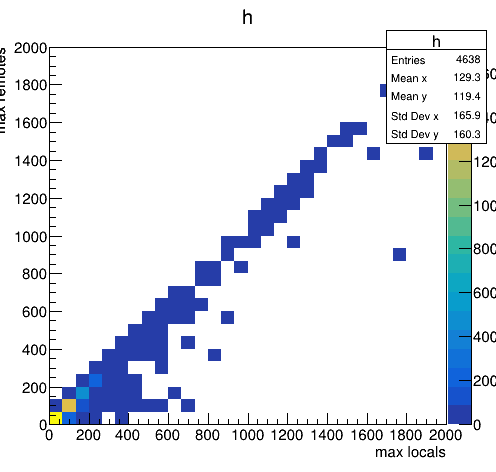

In [9]:
# snake_df.plot(x="Max Local", y="Max Remote")

m_locals = np.array(snake_df["Max Local"])
m_remotes = np.array(snake_df["Max Remote"])

c = ROOT.TCanvas("c", "c", 500, 500)
th2 = ROOT.TH2D("h", "h", 30, 0, 2000, 30, 0, 2000)

for i in range(len(m_locals)):
    th2.Fill(m_locals[i], m_remotes[i])

th2.Draw("colz")
th2.GetXaxis().SetTitle("max locals")
th2.GetYaxis().SetTitle("max remotes")
c.Draw()

(array([1220.,  367.,  628.,  392.,  569.,  334.,  584.,  182.,  102.,
         260.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

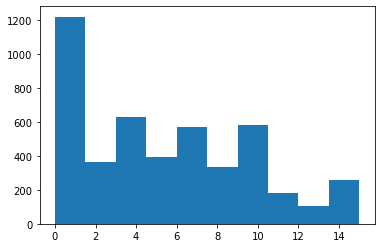

In [10]:
maxIndex = np.array(snake_df["Remote Max"].map(np.argmax))
plt.hist(maxIndex)

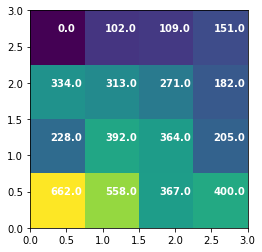

In [11]:
import matplotlib.pyplot as plt

ax = np.stack(np.array(snake_df["AsicX"]))
ay = np.stack(np.array(snake_df["AsicY"]))

max_ax = [ ax[i, maxIndex[i]] for i in range(len(maxIndex)) ]
max_ay = [ ay[i, maxIndex[i]] for i in range(len(maxIndex)) ]

fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = ax.hist2d(max_ax, max_ay, bins=(4,4))

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, hist.T[i,j], 
                color="w", ha="center", va="center", fontweight="bold")

[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3] [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3] 30350726.0
getting ax


(<matplotlib.image.AxesImage at 0x7fe7334c6a00>,
 <matplotlib.colorbar.Colorbar at 0x7fe7334f6940>)

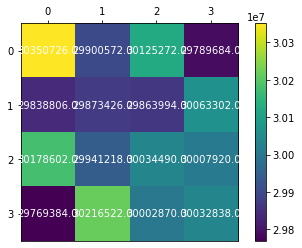

In [12]:
from QpixAsicArray import heatMap

ax = np.array(snake_df["AsicX"])[0]
ay = np.array(snake_df["AsicY"])[0]
afrqs = np.array(snake_df["Frq"])[0]

print(ax, ay, afrqs[0])

frqs = np.zeros((4,4))
for i in range(len(ax)):
        frqs[int(i/4)][i%4] = afrqs[i]

heatMap(frqs, 4, 4)

In [13]:
neut_df = pd.read_csv("neut_table_data.csv")
neut_df.columns = neut_df.iloc[0]
neut_df = neut_df[1:]
neut_df["99"] = neut_df["99\% Capture"].map(float)
neut_df["lepPdg"] = neut_df["lepton Pdg"].map(int)
neut_df["t"] = neut_df["Theta"].map(int)
neut_df["z"] = neut_df["Z-Pos"].map(int)
def makeFHC(string):
    if string.lower() == 'reverse':
        return -1
    return 1
neut_df["fhc"] = neut_df["Horn Current Direction"].map(makeFHC)
print(neut_df['fhc'])

1      1
2      1
3      1
4      1
5      1
      ..
346   -1
347   -1
348   -1
349   -1
350   -1
Name: fhc, Length: 350, dtype: int64


In [14]:
print(neut_df.columns, neut_df["Horn Current Direction"])

Index([                       0,             'lepton Pdg',
       'Horn Current Direction',                  'Z-Pos',
                        'Theta',           '95\% Capture',
                 '99\% Capture',                     '99',
                       'lepPdg',                      't',
                            'z',                    'fhc'],
      dtype='object', name=0) 1      forward
2      forward
3      forward
4      forward
5      forward
        ...   
346    reverse
347    reverse
348    reverse
349    reverse
350    reverse
Name: Horn Current Direction, Length: 350, dtype: object


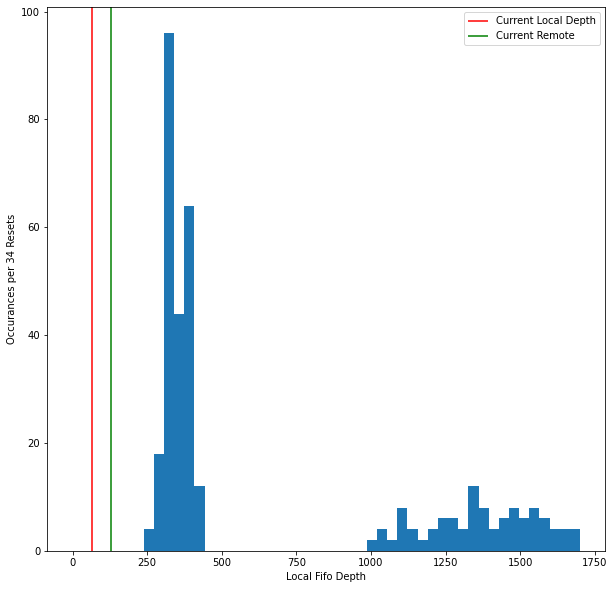

In [15]:
## png hist
pdgData, labels = [], ['elec', 'aelec', 'muon', 'amuon']
pdgData.append(neut_df[neut_df["lepPdg"] == 12]["99"])
pdgData.append(neut_df[neut_df["lepPdg"] == -12]["99"])
pdgData.append(neut_df[neut_df["lepPdg"] == 14]["99"])
pdgData.append(neut_df[neut_df["lepPdg"] == -14]["99"])


fig, ax = plt.subplots(figsize=(10,10))
# ax.hist(pdgData, stacked=True, histtype='bar', bins=50, range=(200,1700), label=labels)
# ax.legend()
ymax, *_ = ax.hist(neut_df["99"], stacked=True, histtype='bar', bins=50, range=(0,1700))
ax.vlines([64], 0, 1, transform=ax.get_xaxis_transform(), colors='r', label="Current Local Depth")
ax.vlines([128], 0, 1, transform=ax.get_xaxis_transform(), colors='g', label="Current Remote")
ax.set_xlabel("Local Fifo Depth")
ax.set_ylabel("Occurances per 34 Resets")
ax.legend()
plt.savefig("./pdfs/df_nolabel_line.pdf")

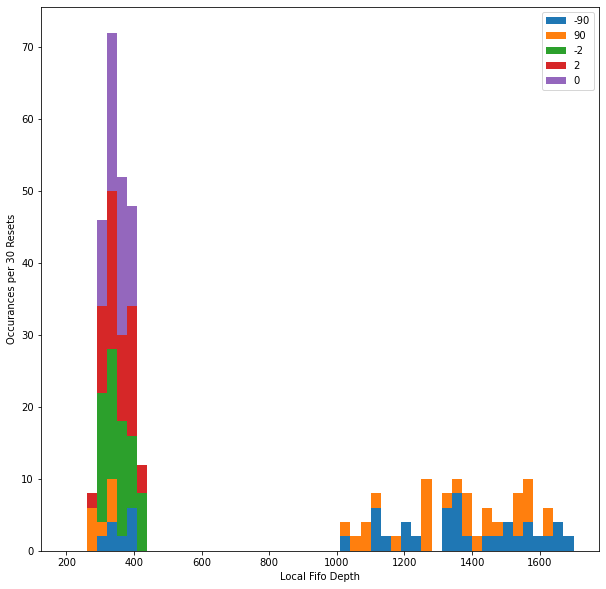

In [16]:
thetaData, labels = [], ['-90', '90', '-2', '2', '0']
thetaData.append(neut_df[neut_df["t"] == -90]["99"])
thetaData.append(neut_df[neut_df["t"] == 90]["99"])
thetaData.append(neut_df[neut_df["t"] == -2]["99"])
thetaData.append(neut_df[neut_df["t"] == 2]["99"])
thetaData.append(neut_df[neut_df["t"] == 0]["99"])


fig, ax = plt.subplots(figsize=(10,10))
ax.hist(thetaData, stacked=True, histtype='bar', bins=50, range=(200,1700), label=labels)
ax.legend()
ax.set_xlabel("Local Fifo Depth")
ax.set_ylabel("Occurances per 30 Resets")
plt.savefig("./pdfs/df_theta_cut.pdf")

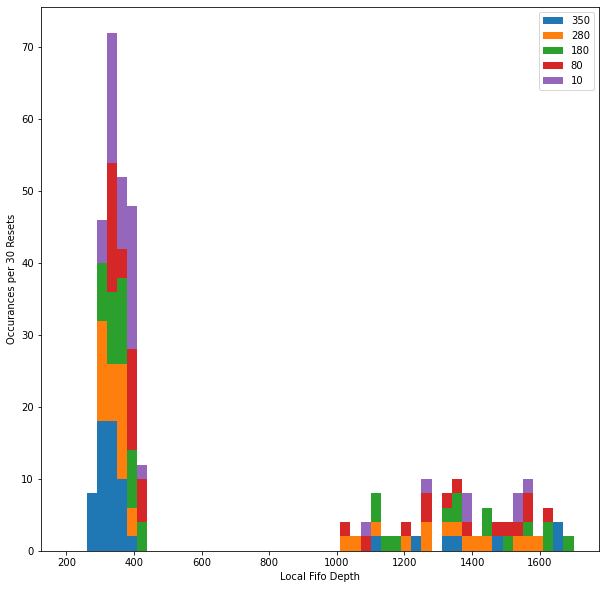

In [17]:
thetaData, labels = [], ['350', '280', '180', '80', '10']
thetaData.append(neut_df[neut_df["z"] == 350]["99"])
thetaData.append(neut_df[neut_df["z"] == 280]["99"])
thetaData.append(neut_df[neut_df["z"] == 180]["99"])
thetaData.append(neut_df[neut_df["z"] == 80]["99"])
thetaData.append(neut_df[neut_df["z"] == 10]["99"])


fig, ax = plt.subplots(figsize=(10,10))
ax.hist(thetaData, stacked=True, histtype='bar', bins=50, range=(200,1700), label=labels)
ax.legend()
ax.set_xlabel("Local Fifo Depth")
ax.set_ylabel("Occurances per 30 Resets")
plt.savefig("./pdfs/df_zpos_cut.pdf")

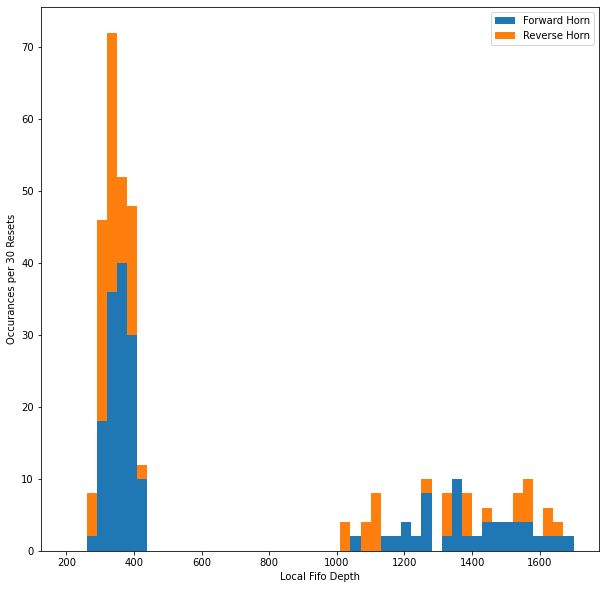

In [18]:
thetaData, labels = [], ['Forward Horn', 'Reverse Horn']
thetaData.append(neut_df[neut_df["fhc"] == 1]["99"])
thetaData.append(neut_df[neut_df["fhc"] == -1]["99"])


fig, ax = plt.subplots(figsize=(10,10))
ax.hist(thetaData, stacked=True, histtype='bar', bins=50, range=(200,1700), label=labels)
ax.legend()
ax.set_xlabel("Local Fifo Depth")
ax.set_ylabel("Occurances per 30 Resets")
plt.savefig("./pdfs/df_horn_cut.pdf")

array([[<AxesSubplot:title={'center':'99'}>]], dtype=object)

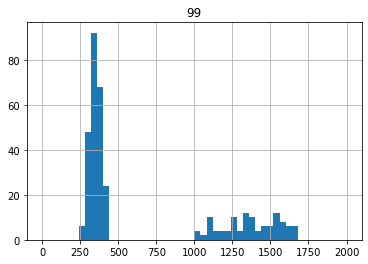

In [19]:
neut_df.hist("99", bins=50, range=(0,2000))

evt found at entry:  26574
1.0 0.0 1800.0 956.392578125 133 3418


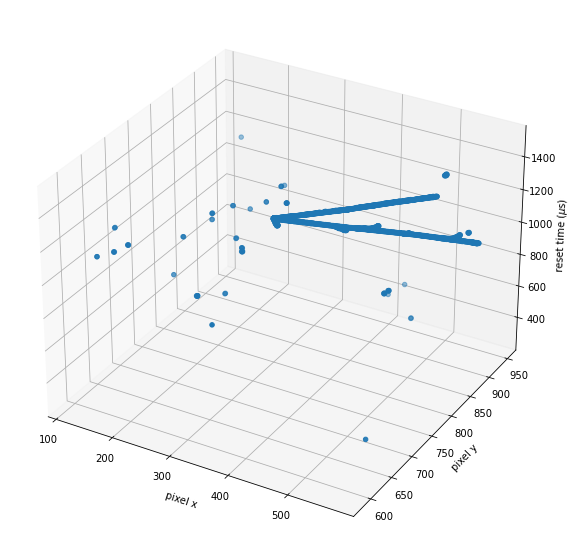

In [20]:
from array import array
tf = ROOT.TFile("../../data_rtd/single_electron_nu_fhc_files.root", "READ")
tt = tf.event_tree
pix_x = ROOT.std.vector('Int_t')()
pix_y = ROOT.std.vector('Int_t')()
pix_r = ROOT.std.vector('Double_t')()
evt_e = array('f', [ 0. ])
lep_e = array('f', [ 0. ])
hadtot_e = array('f', [ 0. ])
hadother_e = array('f', [ 0. ])
axis_x = array('f', [ 0. ])
axis_z = array('f', [ 0. ])
zpos = array('f', [ 0. ])
evtN = array('l', [ 0 ])
fileN = array('l', [ 0 ])
tt = tf.event_tree
tt.SetBranchAddress('pixel_x', pix_x)
tt.SetBranchAddress('pixel_y', pix_y)
tt.SetBranchAddress('pixel_reset', pix_r)
tt.SetBranchAddress('energy_deposit', evt_e)
tt.SetBranchAddress('lepKE', lep_e)
tt.SetBranchAddress('hadTot', hadtot_e)
tt.SetBranchAddress('hadOther', hadother_e)
# posittion information
tt.SetBranchAddress('zpos', zpos)
tt.SetBranchAddress('axis_x', axis_x)
tt.SetBranchAddress('axis_z', axis_z)
# which file number
tt.SetBranchAddress('fsFileNo', fileN)
tt.SetBranchAddress('fsEvt', evtN)
# tt.Print()
for i in range(tt.GetEntries()):
    tt.GetEntry(i)
    if (fileN[0] == 133 and evtN[0] == 3418 and zpos[0] == 1800 and axis_x[0] == 1 and axis_z[0] == 0):
        break
print("evt found at entry: ", i)
import numpy as np
x = np.array(pix_x, dtype=np.double)
y = np.array(pix_y, dtype=np.double)
r = np.array(pix_r, dtype=np.double)
tg2 = ROOT.TGraph2D(len(pix_x), x, y, r)
print(axis_x[0], axis_z[0], zpos[0], evt_e[0], fileN[0], evtN[0])
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


ax.scatter(x, y, r*1e6)

ax.set_xlabel('pixel x')
ax.set_ylabel('pixel y')
ax.set_zlabel('reset time ($\mu$s)')
plt.savefig("./pdfs/example_xdir_scatter.pdf")

evt found at entry:  49684
0.0 1.0 1800.0 1240.8631591796875 133 3418


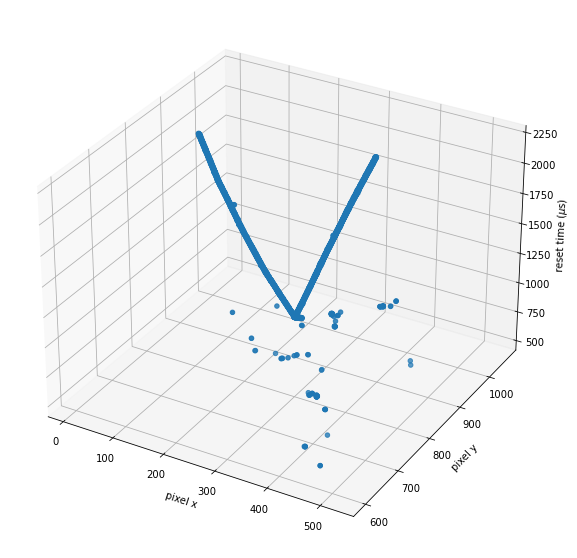

In [21]:
from array import array
tf = ROOT.TFile("../../data_rtd/single_electron_nu_fhc_files.root", "READ")
tt = tf.event_tree
pix_x = ROOT.std.vector('Int_t')()
pix_y = ROOT.std.vector('Int_t')()
pix_r = ROOT.std.vector('Double_t')()
evt_e = array('f', [ 0. ])
lep_e = array('f', [ 0. ])
hadtot_e = array('f', [ 0. ])
hadother_e = array('f', [ 0. ])
axis_x = array('f', [ 0. ])
axis_z = array('f', [ 0. ])
zpos = array('f', [ 0. ])
evtN = array('l', [ 0 ])
fileN = array('l', [ 0 ])
tt = tf.event_tree
tt.SetBranchAddress('pixel_x', pix_x)
tt.SetBranchAddress('pixel_y', pix_y)
tt.SetBranchAddress('pixel_reset', pix_r)
tt.SetBranchAddress('energy_deposit', evt_e)
tt.SetBranchAddress('lepKE', lep_e)
tt.SetBranchAddress('hadTot', hadtot_e)
tt.SetBranchAddress('hadOther', hadother_e)
# posittion information
tt.SetBranchAddress('zpos', zpos)
tt.SetBranchAddress('axis_x', axis_x)
tt.SetBranchAddress('axis_z', axis_z)
# which file number
tt.SetBranchAddress('fsFileNo', fileN)
tt.SetBranchAddress('fsEvt', evtN)
# tt.Print()
for i in range(tt.GetEntries()):
    tt.GetEntry(i)
    if (fileN[0] == 133 and evtN[0] == 3418 and zpos[0] == 1800 and axis_x[0] == 0 and axis_z[0] == 1):
        break
print("evt found at entry: ", i)
import numpy as np
x = np.array(pix_x, dtype=np.double)
y = np.array(pix_y, dtype=np.double)
r = np.array(pix_r, dtype=np.double)
tg2 = ROOT.TGraph2D(len(pix_x), x, y, r)
print(axis_x[0], axis_z[0], zpos[0], evt_e[0], fileN[0], evtN[0])
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


ax.scatter(x, y, r*1e6)

ax.set_xlabel('pixel x')
ax.set_ylabel('pixel y')
ax.set_zlabel('reset time ($\mu$s)')
plt.savefig("./pdfs/example_zdir_scatter.pdf")

In [22]:
from array import array
tf = ROOT.TFile("../../pdfs/ana_electron_fhc.root", "READ")
tt = tf.event_tree
pix_x = ROOT.TH2
pix_y = ROOT.std.vector('Int_t')()
pix_r = ROOT.std.vector('Double_t')()
evt_e = array('f', [ 0. ])
lep_e = array('f', [ 0. ])
hadtot_e = array('f', [ 0. ])
hadother_e = array('f', [ 0. ])
axis_x = array('f', [ 0. ])
axis_z = array('f', [ 0. ])
zpos = array('f', [ 0. ])
evtN = array('l', [ 0 ])
fileN = array('l', [ 0 ])
tt = tf.event_tree
tt.SetBranchAddress('pixel_x', pix_x)
tt.SetBranchAddress('pixel_y', pix_y)
tt.SetBranchAddress('pixel_reset', pix_r)
tt.SetBranchAddress('energy_deposit', evt_e)
tt.SetBranchAddress('lepKE', lep_e)
tt.SetBranchAddress('hadTot', hadtot_e)
tt.SetBranchAddress('hadOther', hadother_e)
# posittion information
tt.SetBranchAddress('zpos', zpos)
tt.SetBranchAddress('axis_x', axis_x)
tt.SetBranchAddress('axis_z', axis_z)
# which file number
tt.SetBranchAddress('fsFileNo', fileN)
tt.SetBranchAddress('fsEvt', evtN)
# tt.Print()
for i in range(tt.GetEntries()):
    tt.GetEntry(i)
    if (fileN[0] == 133 and evtN[0] == 3418 and zpos[0] == 1800 and axis_x[0] == 0 and axis_z[0] == 1):
        break
print("evt found at entry: ", i)
import numpy as np
x = np.array(pix_x, dtype=np.double)
y = np.array(pix_y, dtype=np.double)
r = np.array(pix_r, dtype=np.double)
tg2 = ROOT.TGraph2D(len(pix_x), x, y, r)
print(axis_x[0], axis_z[0], zpos[0], evt_e[0], fileN[0], evtN[0])
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


ax.scatter(x, y, r*1e6)

ax.set_xlabel('pixel x')
ax.set_ylabel('pixel y')
ax.set_zlabel('reset time ($\mu$s)')
plt.savefig("./pdfs/example_zdir_scatter.pdf")

TypeError: Template method resolution failed:
  none of the 3 overloaded methods succeeded. Full details:
  int TTree::SetBranchAddress(const char* bname, void* add, TBranch** ptr = 0) =>
    TypeError: could not convert argument 2
  int TTree::SetBranchAddress(const char* bname, void* add, TBranch** ptr, TClass* realClass, EDataType datatype, bool isptr) =>
    TypeError: takes at least 6 arguments (2 given)
  int TTree::SetBranchAddress(const char* bname, void* add, TClass* realClass, EDataType datatype, bool isptr) =>
    TypeError: takes at least 5 arguments (2 given)
  Failed to instantiate "SetBranchAddress(std::string,TH2)"